# Start

## Run this

In [ ]:
!pip install kaggle

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from time import sleep
import json
import pandas as pd
import io
import re
import numpy as np
from tqdm import tqdm
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tnrange, tqdm_notebook, tqdm
from datetime import datetime
import warnings

from sklearn import preprocessing
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Move the kaggle.json file to the appropriate location
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
#!mv kaggle.json ~/.kaggle/

#shutil.copy('', '/content/.kaggle/')

# Set the environment variables for Kaggle API
os.environ['KAGGLE_CONFIG_DIR'] = '/root/.kaggle'

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
DIR_DATA = './data'
FILE_ZIP_TWEETS = './bitcoin_tweets.zip'
FILE_ZIP_PRICES = './bitcoin_prices.zip'
FILE_BTC_TWEETS = os.path.join(DIR_DATA, 'bitcoin_tweets.csv')
FILE_BTC_PRICES = os.path.join(DIR_DATA, 'bitcoin_prices.csv')

print(os.path.exists(DIR_DATA))

False


In [ ]:
#!kaggle datasets download -d kaushiksuresh147/bitcoin-tweets

if not os.path.exists(FILE_BTC_TWEETS):
  shutil.copy('./drive/MyDrive/clean.zip', './clean.zip')
  os.rename('./clean.zip', './bitcoin_tweets.zip')

if not os.path.exists(FILE_BTC_PRICES):
  !kaggle datasets download -d pavan9065/bitcoin-price-history
  os.rename('./bitcoin-price-history.zip', './bitcoin_prices.zip')

  0% 0.00/75.3k [00:00<?, ?B/s]
100% 75.3k/75.3k [00:00<00:00, 60.3MB/s]


In [ ]:
import zipfile

if not os.path.exists(DIR_DATA):
    os.makedirs(DIR_DATA)

if not os.path.exists('bitcoin_tweets.zip') and not os.path.exists(FILE_BTC_TWEETS):
    print('bitcoin_tweets.zip cannot be found')

if not os.path.exists('bitcoin_prices.zip') and not os.path.exists(FILE_BTC_PRICES):
    print('bitcoin_prices.zip cannot be found')

if not os.path.exists(FILE_BTC_TWEETS) and os.path.exists(FILE_ZIP_TWEETS):
    with zipfile.ZipFile(FILE_ZIP_TWEETS, 'r') as zip_ref:
        zip_ref.extractall(DIR_DATA)
        if os.path.exists(os.path.join(DIR_DATA, 'clean.csv')):
            os.rename(os.path.join(DIR_DATA, 'clean.csv'), FILE_BTC_TWEETS)

if not os.path.exists(FILE_BTC_PRICES) and os.path.exists(FILE_ZIP_PRICES):
    with zipfile.ZipFile(FILE_ZIP_PRICES, 'r') as zip_ref:
        zip_ref.extractall(DIR_DATA)
        if os.path.exists(os.path.join(DIR_DATA, 'BTC-USD.csv')):
            os.rename(os.path.join(DIR_DATA, 'BTC-USD.csv'), FILE_BTC_PRICES)

In [ ]:
tweets = pd.read_csv(FILE_BTC_TWEETS)
tweets = tweets.drop_duplicates()

# tweets = tweets.iloc[:10000,:]

try:
    tweets.date = pd.to_datetime(tweets.date, utc=True)
except:
    tweets = tweets[tweets.date.str.len() == 19]
    tweets.date = pd.to_datetime(tweets.date, utc=True)

tweets.date = tweets.date.dt.tz_localize(None)
tweets.index = tweets['date']

tweets_grouped = tweets.resample('1h').sum()
tweets_grouped.head()

<ipython-input-13-c78b7a37ebc8>:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_grouped = tweets.resample('1h').sum()


,index,compound,score
date,,,
2009-01-11 13:00:00,1,0.0,0.0
2009-01-11 14:00:00,0,0.0,0.0
2009-01-11 15:00:00,0,0.0,0.0
2009-01-11 16:00:00,0,0.0,0.0
2009-01-11 17:00:00,0,0.0,0.0


In [ ]:
crypto_usd = pd.read_csv(FILE_BTC_PRICES)
crypto_usd['Date'] = pd.to_datetime(crypto_usd['Date'])
crypto_usd.index = crypto_usd['Date']
crypto_usd_grouped = crypto_usd.resample('D')['Close'].mean()
crypto_usd_grouped.head()

Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Freq: D, Name: Close, dtype: float64

In [ ]:
def crosscorr(datax, datay, lag=0, method="pearson"):
    """ Lag-N cross correlation.
    Parameters
    —------—
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    —------—
    crosscorr : float
    """
    return datax.corrwith(datay.shift(lag), method=method)['score']

In [ ]:
beggining = max(tweets_grouped.index.min().replace(tzinfo=None), crypto_usd_grouped.index.min())
end = min(tweets_grouped.index.max().replace(tzinfo=None), crypto_usd_grouped.index.max())
tweets_grouped = tweets_grouped[beggining:end]
crypto_usd_grouped = crypto_usd_grouped[beggining:end]

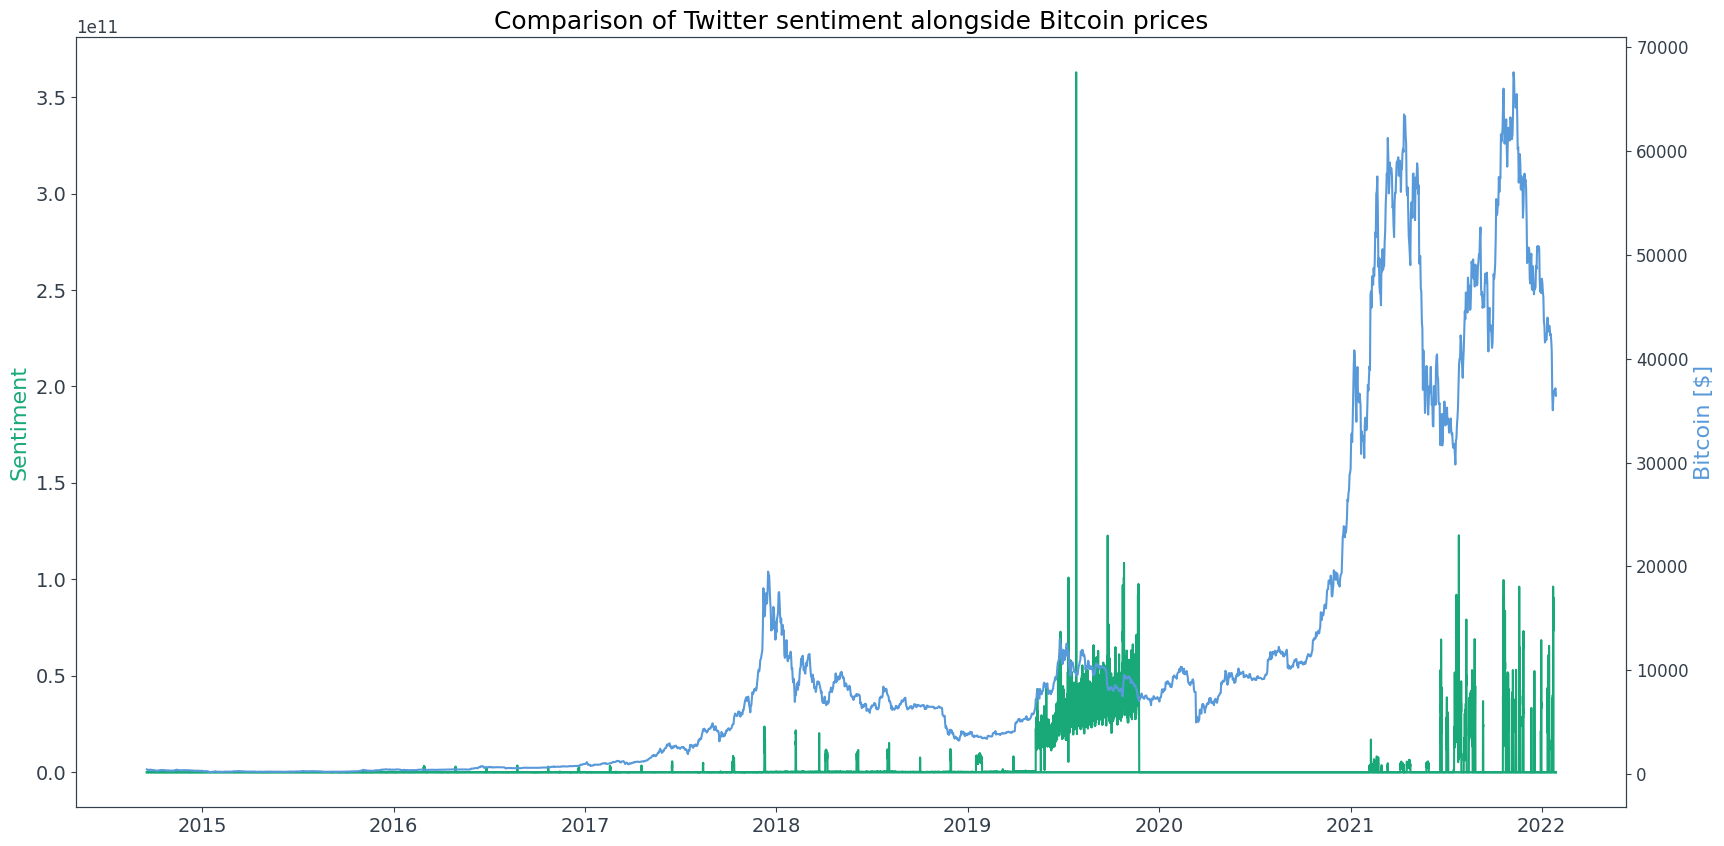

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(20,10))

# Set font for the entire chart and its axes
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.edgecolor'] = '#333F4B'
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['xtick.color'] = '#333F4B'
plt.rcParams['ytick.color'] = '#333F4B'

ax1.set_title("Comparison of Twitter sentiment alongside Bitcoin prices", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped, '#19a979')
ax2.plot_date(crypto_usd_grouped.index, crypto_usd_grouped, '#5899da')

ax1.set_ylabel("Sentiment", color='#19a979', fontsize=16)
ax2.set_ylabel("Bitcoin [$]", color='#5899da', fontsize=16)
plt.show()

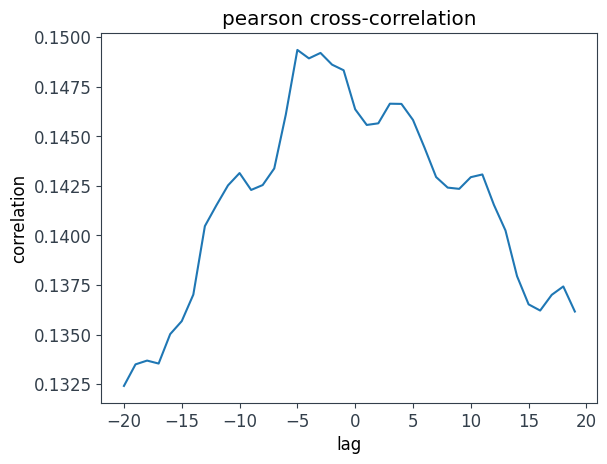

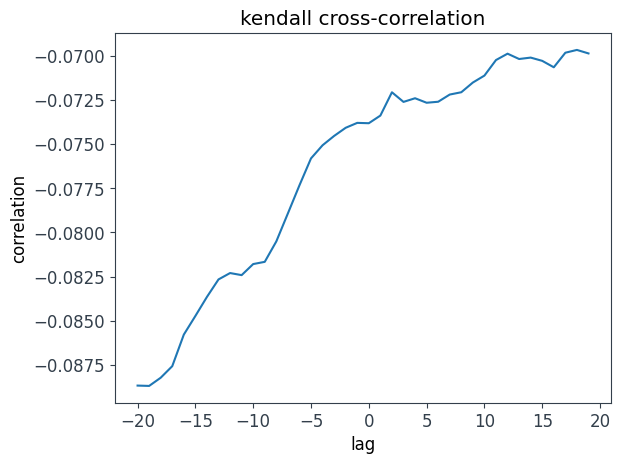

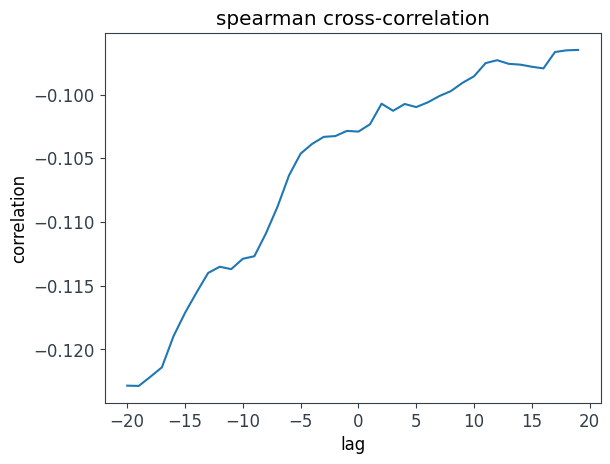

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

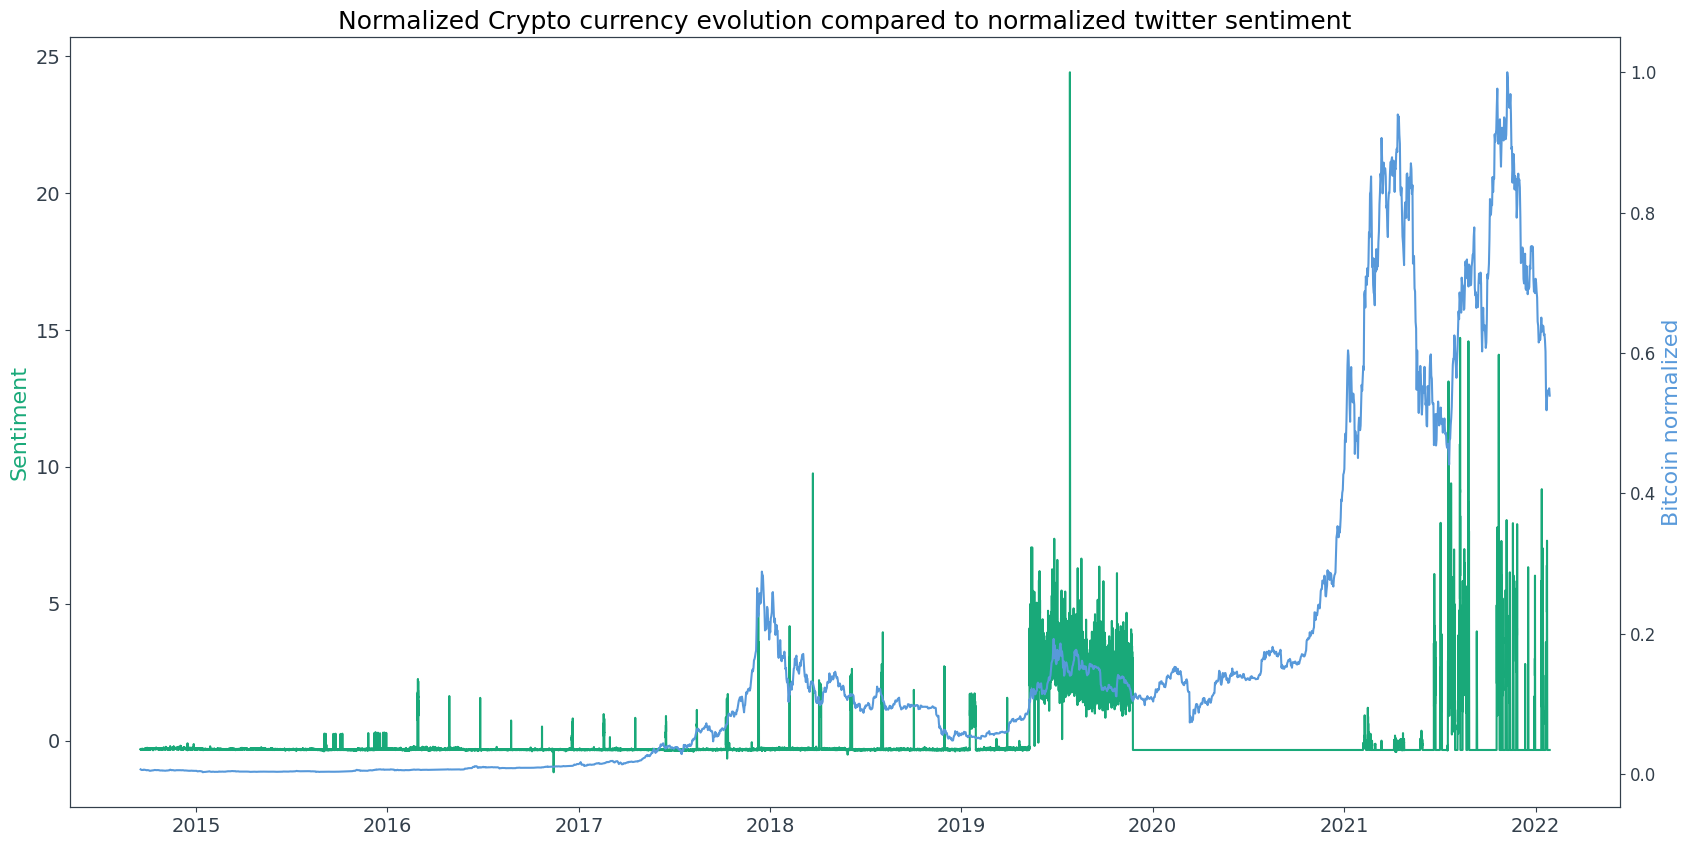

In [ ]:
# Normalize time series data
min_max_scaler = preprocessing.StandardScaler()
score_scaled = min_max_scaler.fit_transform(tweets_grouped['score'].values.reshape(-1,1))
tweets_grouped['normalized_score'] = score_scaled
# crypto_used_grouped_scaled = min_max_scaler.fit_transform(crypto_usd_grouped.values.reshape(-1,1))
crypto_used_grouped_scaled = crypto_usd_grouped / max(crypto_usd_grouped.max(), abs(crypto_usd_grouped.min()))
# crypto_usd_grouped['normalized_price'] = crypto_used_grouped_scaled

fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Normalized Crypto currency evolution compared to normalized twitter sentiment", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped.index, tweets_grouped['normalized_score'], '#19a979')
ax2.plot_date(crypto_usd_grouped.index, crypto_used_grouped_scaled, '#5899da')

ax1.set_ylabel("Sentiment", color='#19a979', fontsize=16)
ax2.set_ylabel("Bitcoin normalized", color='#5899da', fontsize=16)
plt.show()

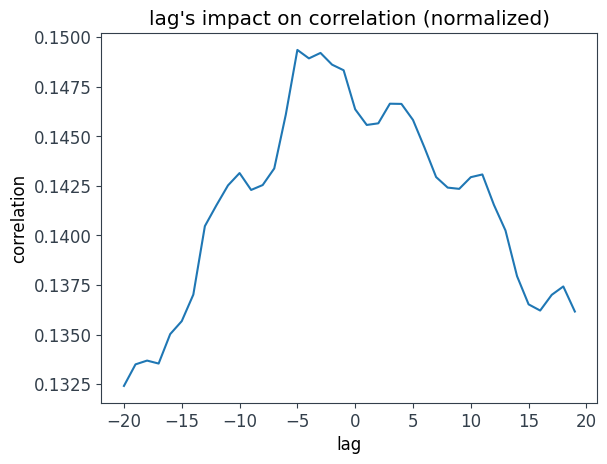

In [ ]:
#tweets_grouped.T.corr(crypto_usd_grouped, method='pearson')
#tweets_grouped.T.autocorr(crypto_usd_grouped, lag=20)
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped, lag=i) for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("lag's impact on correlation (normalized)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

In [ ]:
# Derivative
tweets_grouped_derivative = pd.Series(np.gradient(tweets_grouped['normalized_score'].values), tweets_grouped.index, name='slope')
crypto_usd_grouped_derivative = pd.Series(np.gradient(crypto_usd_grouped.values), crypto_usd_grouped.index, name='slope')

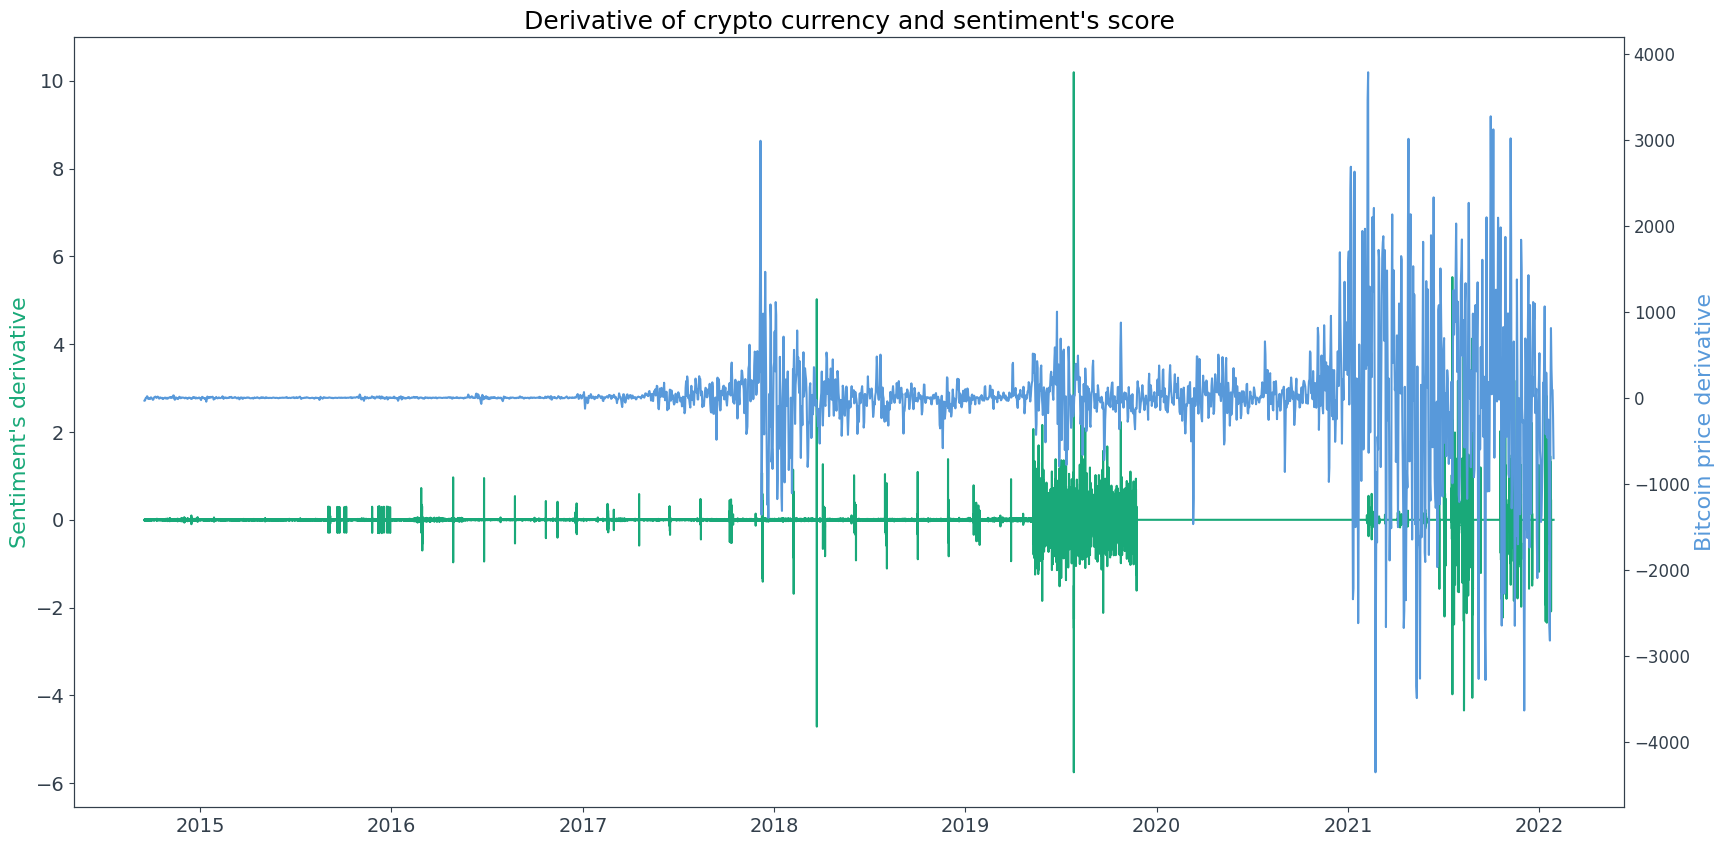

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Derivative of crypto currency and sentiment's score", fontsize=18)
ax1.tick_params(labelsize=14)

ax2 = ax1.twinx()
ax1.plot_date(tweets_grouped_derivative.index, tweets_grouped_derivative, '#19a979')
ax2.plot_date(crypto_usd_grouped_derivative.index, crypto_usd_grouped_derivative, '#5899da')

ax1.set_ylabel("Sentiment's derivative", color='#19a979', fontsize=16)
ax2.set_ylabel('Bitcoin price derivative', color='#5899da', fontsize=16)
plt.show()

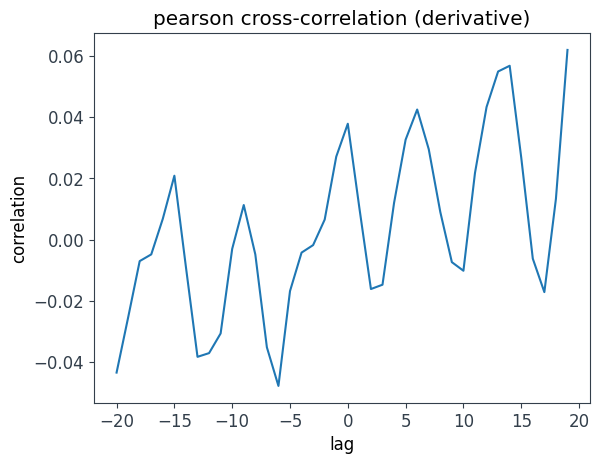

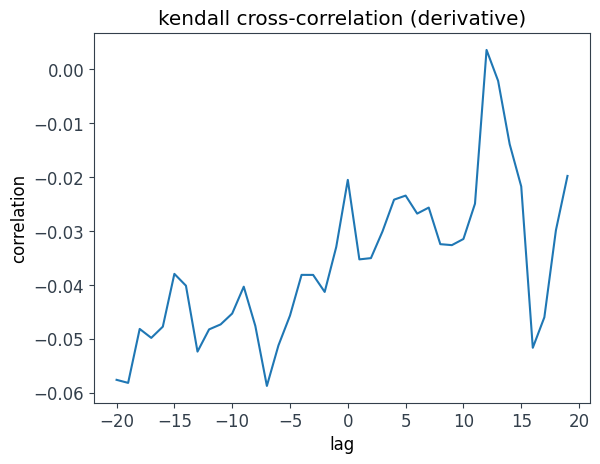

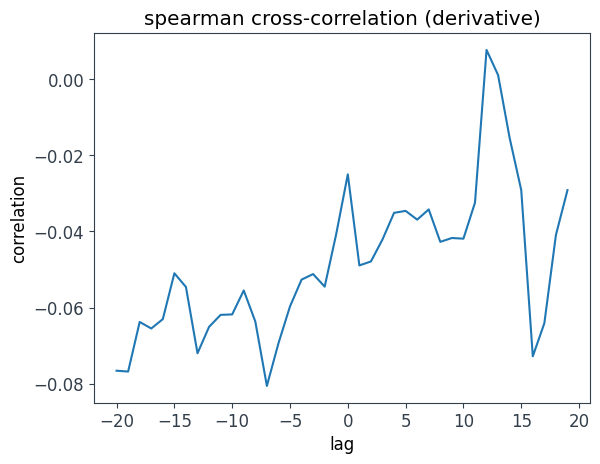

In [ ]:
xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="pearson") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("pearson cross-correlation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="kendall") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("kendall cross-correlation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

xcov = [crosscorr(tweets_grouped, crypto_usd_grouped_derivative, lag=i, method="spearman") for i in range(-20,20)]
plt.plot(range(-20,20), xcov)
plt.title("spearman cross-correlation (derivative)")
plt.xlabel("lag")
plt.ylabel("correlation")
plt.show()

## Run this

In [ ]:
def cleanup_data(df):

  # We need to ensure that our dataset contains records where both the 'date'
  # and 'text' fields are present. For records, where any one of these is not
  # present, we simply drop the records and recalculate the indices.

  def remove_missing_information(df):
    df.dropna(axis=0, subset=['date', 'text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

  df = remove_missing_information(df)

  # Furthermore, we need to also remove any duplicate entries from the dataset
  # in order to ensure that a certain record does not skew the results for our
  # experiments

  def remove_duplicates(df):
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

  df = remove_duplicates(df)

  # Based on the values found in our dataset, the data type for each column is
  # inferred for further processing.

  df = df.convert_dtypes()
  return df

In [ ]:
df = cleanup_data(df)

NameError: ignored

In [ ]:
def cleanup_dates(df):
  pd.set_option('mode.chained_assignment', None)

  # We begin by validating entries within our dataset for whether they contain
  # a valid date or not. This helps us gather dates that are invalid so that
  # they can be fixed subsequently.

  def get_invalid_date_entries(dates):
    invalid = []
    for i,v in enumerate(tqdm(dates, position=0, leave=True)):
      try:
        datetime.strptime(v, '%Y-%m-%d %H:%M:%S')
      except ValueError:
        invalid.append(i)
    return invalid

  # Retrieve a list of all entries where the 'date' column has invalid entries
  # for dates and remove those entries from the dataset.

  invalid_dates = get_invalid_date_entries(df['date'])
  print('There were '+str(len(invalid_dates)) +' records with invalid dates')
  df = df.loc[~df.index.isin(invalid_dates)]
  df.reset_index(drop=True, inplace=True)
  df = df.assign(
      date=pd.to_datetime(df['date'],
                          format='%Y-%m-%d %H:%M:%S'))


  # We also need to ensure that date range for the entries that are present in
  # our dataset to further strategise our data federation efforts.

  def get_date_range(df):
    min_date = df['date'].min()
    max_date = df['date'].max()
    return (min_date, max_date)

  # As of writing this Python code, the minimum date was '2021-02-05 10:52:04'
  # and the maximum date was '2023-01-09 23:59:54'

  min_date, max_date = get_date_range(df)
  print('Minimum date: ', min_date)
  print('Maximum date: ', max_date)

  pd.reset_option("mode.chained_assignment")
  return df

In [ ]:
df = cleanup_dates(df)

In [ ]:
df['user_followers'] = pd.to_numeric(df['user_followers'], errors='coerce').astype('Int64')
df['user_friends'] = pd.to_numeric(df['user_friends'], errors='coerce').astype('Int64')
df['user_favourites'] = pd.to_numeric(df['user_favourites'], errors='coerce').astype('Int64')
df.dtypes

In [ ]:
df1 = df.loc[(df['date'] >= '2021-01-01') & (df['date'] <= '2021-12-31')].reset_index(drop=True)
df1.head()

In [ ]:

import re
import pandas as pd
import gc
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def clean_text(df):
    # Clean the 'text' column
    df['text'] = df['text'].str.replace("#", "")
    #df['text'] = df['text'].str.replace("(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", " ")
    df['text'] = df['text'].str.replace('@\\w+ *', '')
    df['text'] = df['text'].str.lower()

    # Perform cleaning on a subset of records at a time
    chunk_size = 10000
    num_chunks = len(df) // chunk_size + 1

    # Clean the 'hashtags' column
    irrelevant_hashtags = ['nft', 'giveaway', 'cashback', 'airdrop']
    df['hashtags'] = df['hashtags'].str.lower()
    df = df[~df['hashtags'].str.contains('|'.join(irrelevant_hashtags))]
    df.reset_index(drop=True, inplace=True)

    return df

df1 = clean_text(df1)
df1.head()

# Trigger garbage collection to release unused objects from memory
gc.collect()

In [ ]:
gc.collect()

In [ ]:
df1.head()

In [ ]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the vaderSentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply vaderSentiment for polarity analysis
df1['polarity'] = df1['text'].apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Apply TextBlob for subjectivity analysis
df1['subjectivity'] = df1['text'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

df1.head()

In [ ]:
df1.head(20)

In [ ]:
df_clean = df_date_clean_final.copy()
df_clean.head()

In [ ]:
df_clean['text'] = df_clean.apply(lambda row: word_tokenize(row['text']), axis=1)

In [ ]:
df_clean.head()

In [ ]:
stop_words = set(stopwords.words('english'))
df_clean['text'] = df_clean.apply(lambda row: (" ".join([word for word in row['text'] if word not in stop_words])),axis=1)

In [ ]:
df_clean[['polarity', 'subjectivity']] = df_clean['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [ ]:
df_clean.head()

In [ ]:
df_clean_copy = df_clean.copy()

In [ ]:
df_sentiment = df_clean.copy()

In [ ]:
df_sentiment['Sentiment'] = df_sentiment["polarity"].apply(lambda x: "Positive" if x > 0 else( "Negative" if x < 0  else "Nuetral"))

In [ ]:
df_sentiment.drop(['user_description','user_created','source','polarity','subjectivity'],axis=1,inplace=True)
df_sentiment.head()

In [ ]:
location_df = df_sentiment.copy()

In [ ]:
location_df.loc[location_df['user_location'].str.isnumeric(), 'user_location'] = 'Unknown'
location_df.user_location = location_df.user_location.fillna('Unknown')
location_df.loc[location_df['user_location'].str.contains('#', case=False), 'user_location'] = 'Unknown'
location_df.loc[location_df['user_location'].str.contains('@', case=False), 'user_location'] = 'Unknown'
location_df.head()

In [ ]:
spacy_df = location_df.loc[~(location_df['user_location'] == 'Unknown')]
spacy_df.shape

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
def check_for_gpe(text):
    doc = nlp(text)
    lst = [x.label_ for x in doc.ents]
    if 'GPE'  in lst: return True
    else: return False

In [ ]:
spacy_df['IsLoc'] = spacy_df[:100]['user_location'].apply(lambda row: check_for_gpe(row))

In [ ]:
spacy_df.head(15)

In [ ]:
geopy_df = spacy_df.loc[spacy_df['IsLoc']== True]
geopy_df.shape

In [ ]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter

def do_geocode(address):
    geolocator = Nominatim(user_agent='btc_agent')
    geopy = RateLimiter(geolocator.geocode, max_retries=2,min_delay_seconds=1) #I recommend using a limiter so it will take a little less time
    return geopy(address,exactly_one=True,language='en')

#Creating Geocoded Location column
geopy_df['GeocodedLocation']=geopy_df['user_location'].apply(lambda x: do_geocode(x) if x != None else None)

<ipython-input-54-b4c5a310ac8f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geopy_df['GeocodedLocation']=geopy_df['user_location'].apply(lambda x: do_geocode(x) if x != None else None)


In [ ]:
geopy_df.head(10)

In [ ]:
#Keeping only the country
geopy_df['Country'] = geopy_df['GeocodedLocation'].apply(lambda loc: str(loc).split(',')[-1] if loc else 'Unknown')
geopy_df.head(10)

In [ ]:
df_price = pd.read_csv(bit_price_file2)
df_price.Date = pd.to_datetime(df_price.Date)
# df_price.Timestamp = pd.to_datetime(df_price.Timestamp,unit='s')
df_price.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200


In [ ]:
df_clean_copy.head()

In [ ]:
scores = []
for i, s in tqdm(df_clean_copy.iterrows(), total=df_clean_copy.shape[0],position=0, leave=True):
    try:
        scores.append(s["polarity"] * ((int(s["user_followers"]))) * ((int(s["user_favourites"])+1)/int(s['user_followers']+1)) *((int(s["is_retweet"])+1)))
    except:
        scores.append(np.nan)
df_clean_copy["score"] = scores
df_clean_copy.head()

https://www.kaggle.com/code/erdeq1024/bitcoin-price-analysis-by-tweets

In [ ]:
pd.read_csv(tweets_raw_file,low_memory=False)